# Final Project #
#### CSCI 4831 - Sabermetrics ####
#### Instructor: Rhonda Hoenigman ####
#### Name: Hussain Quadri ####

In [1]:
#Import Statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pybaseball import pitching_stats_range, pitching_stats_bref
from pybaseball import statcast
%matplotlib inline


## Introduction ## 

My idea is based around one of the questions we have come across in the assignments; how do we determine how good a player truly is? I would like to take a tangent from that and answer the question “How can we measure a pitcher’s efficiency?” This is where my statistic comes in. The point of this statistic is to easily determine the performance or play style of a pitcher using a generalized score. The statistic is called "Pitching Quality".

I will be using statcast for all my data. Initially I will limit it to one season just for a smaller dataset, then adapt it and check if it works with many years of data. It is basically a combination of existing statistics in statcast being merged together as one single score. I would be applying a certain weight to each statistic and calculate my new statistic using that, perhaps as an average or on a percentage scale (which would involve finding the maximum value of this statistic over a few years, and scale accordingly). The variables I think would be useful are bb_type (Type of hit), v(x,y,z)0/a(x,y,z) (The acceleration and velocities of throws in 3 dimensions), effective_speed, release_spin, launch_speed, and launch_speed_angle. I believe the velocity, acceleration, and launch speed angles will have a higher weightage than the other variables, but I am currently unsure of how to balance these. 
  
I do see a few flaws with my approach. The main one would be that this is a completely biased statistic, based on a weighting system that I decide upon. Second, there are other factors that could contribute to a pitcher’s performance, such as playing on home field vs away, the weather, when the pitcher was put into a game, etc. However, the aim is just to create a general-purpose statistic that can generalize the performance of pitchers and give them a ranking. 


## What's Different? ##

Most pitching statistics are tailored to show how offensive a pitcher can be, what the results of their performance is, etc. Using this knowledge, my aim was to create something that generalised the quality of pitches thrown by players, and something that does not correlate as well to these performance stats. What Pitching Quality does is take pitch related variables to evaluate how "good" a pitch truly is, by combining them. Now, this does no necessarily mean that a high pitch quality results in the best pitchers in a game, but it does show the potential of how quality pitchers could eventually rise up the rankings.


## Heuristic ##

As you will see below, the way I am calculating my statistic is by weighting a few variables and taking a weighted average:

$$ PitchingQuality = 
\frac{(10*LaunchSpeedAngle) + (9*vz0) + (8*ay) + (7*EffectiveSpeed) + (6*az) + (5*vy0) + (4*LaunchSpeed) + (3*vx0) + (2*ax) + ReleaseSpinRate}{55*100}$$

## Data & Statistics

In [2]:
# Data grabbing
# data = statcast('2017-01-01', '2018-12-31')
pitchers_2017 = pd.read_csv("Statcast_Pitching_Data_2017.csv", low_memory=False)
pitchers_2018 = pd.read_csv("Statcast_Pitching_Data_2018.csv", low_memory=False)
pitchers = pd.concat([pitchers_2017, pitchers_2018])

In [3]:
pitchers.head(5)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,SL,2017-10-01,84.8,-1.7864,6.2820,George Kontos,645302,502004,strikeout,swinging_strike,...,8,11,8,11,11,8,8,11,Standard,Standard
1,SL,2017-10-01,85.5,-1.6885,6.2841,George Kontos,645302,502004,NaN,blocked_ball,...,8,11,8,11,11,8,8,11,Standard,Standard
2,SL,2017-10-01,85.5,-1.7503,6.3259,George Kontos,645302,502004,NaN,swinging_strike,...,8,11,8,11,11,8,8,11,Standard,Standard
3,FC,2017-10-01,89.1,-2.0060,6.2080,George Kontos,645302,502004,NaN,called_strike,...,8,11,8,11,11,8,8,11,Standard,Standard
4,FT,2017-10-01,95.3,1.8362,6.1102,Dan Runzler,457477,502130,single,hit_into_play_score,...,7,11,7,11,11,7,7,11,Standard,Standard


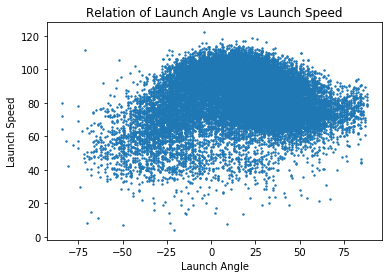

In [4]:
#Choosing variables

d = pitchers.copy()
fig, ax1 = plt.subplots()
ax1.set_xlabel("Launch Angle")
ax1.set_ylabel("Launch Speed")
ax1.set_title("Relation of Launch Angle vs Launch Speed")
ax1.scatter(d.launch_angle, d.launch_speed, s=2)


It is interesting to see here how fast a ball is thrown depending on the angle it is thrown at, the sweet spot being anywhere from 0-50 degrees, suggesting fast straight/curve balls. This makes me think that these variables have an importance in pitching quality.

In [5]:
# Filter data for just bb_type, v(x,y,z)0/a(x,y,z) effective_speed, release_spin, launch_speed, and launch_speed_angle


filtered_data = pitchers[['player_name',
                 'pitcher',
                 'bb_type',
                 'vx0', 'vy0', 'vz0',
                 'ax', 'ay', 'az',
                 'effective_speed',
                 'release_spin_rate',
                 'launch_speed',
                 'launch_speed_angle', 'woba_value', 'estimated_ba_using_speedangle']].groupby('player_name', as_index = False).mean()
filtered_data.head(10)

,player_name,pitcher,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,launch_speed,launch_speed_angle,woba_value,estimated_ba_using_speedangle
0,A.J. Cole,595918,8.130867,-127.245366,-4.900360,-6.001001,25.793299,-20.569028,87.972881,2115.190244,83.737500,3.400000,0.407843,0.365057
1,A.J. Griffin,456167,7.315173,-111.576357,-1.819155,-4.818716,20.601927,-25.342316,76.914273,2303.795455,86.082353,2.923077,0.643333,0.364923
2,A.J. Minter,621345,-6.748847,-134.618773,-4.097269,3.343426,26.998237,-20.424095,92.215869,2406.944056,83.250000,3.200000,0.382857,0.381150
3,A.J. Schugel,519263,5.378207,-122.807768,-3.974014,-11.624157,24.676650,-24.567682,83.173500,2044.642857,93.120000,4.000000,1.016667,0.626250
4,AJ Ramos,573109,5.963688,-121.128854,-1.220308,-1.237573,25.911081,-28.563750,82.043615,2402.076923,77.583333,4.000000,0.266667,0.388333
5,Aaron Brooks,605156,8.864200,-128.055554,-4.743154,-10.591100,25.731223,-24.956085,87.371538,1993.769231,77.000000,2.000000,0.466667,0.066000
6,Aaron Bummer,607481,-8.646504,-132.187202,-4.703169,8.927863,26.680237,-27.329586,90.556129,1985.405882,82.363415,2.708333,0.243421,0.280417
7,Aaron Loup,571901,-12.554004,-127.702577,-0.079262,13.436794,25.039665,-28.143413,87.304922,2231.766234,77.182609,2.818182,0.177778,0.227364
8,Aaron Nola,605400,5.059926,-125.049194,-0.536737,-3.765562,25.429751,-28.861864,86.231465,2214.200704,82.313433,2.930233,0.254795,0.299674
9,Aaron Slegers,642083,9.443827,-126.456076,-5.997472,-7.057502,26.480406,-19.760139,88.329178,2003.566667,78.576923,2.705882,0.236364,0.314000


In [6]:
#Finding variance in variables to figure out weighting system

filtered_data.var()

pitcher                          5.141534e+09
vx0                              3.270951e+01
vy0                              2.112535e+01
vz0                              3.395631e+00
ax                               5.243265e+01
ay                               4.163951e+00
az                               1.488782e+01
effective_speed                  1.110381e+01
release_spin_rate                3.348248e+04
launch_speed                     1.587547e+01
launch_speed_angle               1.482612e-01
woba_value                       1.833834e-02
estimated_ba_using_speedangle    7.789864e-03
dtype: float64

In this, we can see the most variance is in the release_spin_rate, and the least in launch_speed_angle.
Weighting will be done on a scale of 1-10, with 1 going to the variable with the highest variance, and 10 going to the variable with the lowest variance.

In [7]:
# Weighted Statistic = PitchingQuality = ((10*launch_speed_angle + 9*vz0 + 8*ay + 7*effective_speed + 6*az
#                                            + 5*vy0 + 4*launch_speed + 3*vx0 + 2*ax + release_spin_rate)/(55*100))

filtered_data['Pitching_Quality'] = ((10*filtered_data['launch_speed_angle'] + 9*filtered_data['vz0'] + 8*filtered_data['ay'] 
                                      + 7*filtered_data['effective_speed'] + 6*filtered_data['az'] + 5*filtered_data['vy0'] 
                                      + 4*filtered_data['launch_speed'] + 3*filtered_data['vx0'] + 2*filtered_data['ax'] 
                                      + filtered_data['release_spin_rate'])/(55*100))

Updated_Data = filtered_data.sort_values(by=['Pitching_Quality'], ascending=False)
Updated_Data.head()

,player_name,pitcher,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,launch_speed,launch_speed_angle,woba_value,estimated_ba_using_speedangle,Pitching_Quality
517,Nik Turley,543867,-6.823205,-129.752862,-3.777267,3.192990,26.276162,-23.091043,89.361952,2838.095238,86.980000,3.666667,0.500000,0.400000,0.586006
526,Pat Venditte,519381,1.465767,-115.887578,1.920261,2.393361,22.111161,-26.632322,79.497722,2794.000000,81.880000,2.400000,0.116667,0.142600,0.575660
542,Ray Black,605143,6.922742,-135.540792,-3.794398,-0.409944,29.114568,-20.203228,92.817480,2748.979592,72.127778,2.625000,0.330769,0.383875,0.569683
606,Shawn Armstrong,542888,7.708582,-131.856105,-4.161079,-1.140330,27.602556,-20.844454,90.420404,2722.176471,77.050000,3.250000,0.446875,0.306875,0.566489
575,Ryan Pressly,519151,1.466149,-131.847819,-5.002214,2.872953,28.159767,-23.759620,89.850463,2741.989474,80.004348,2.857143,0.283333,0.247714,0.565116


In [8]:
print("Average", Updated_Data['Pitching_Quality'].max())
print("Average", Updated_Data['Pitching_Quality'].mean())
print("Average", Updated_Data['Pitching_Quality'].min())

Average 0.5860064121212122
Average 0.47415025650975023
Average 0.34761269090853547


# Comparisons & Conclusion #

Now that we have gathered our data using our updated heuristic, I would like to plot this data and compare it against other more used statistics such as wOBA and Estimated Batting Average.

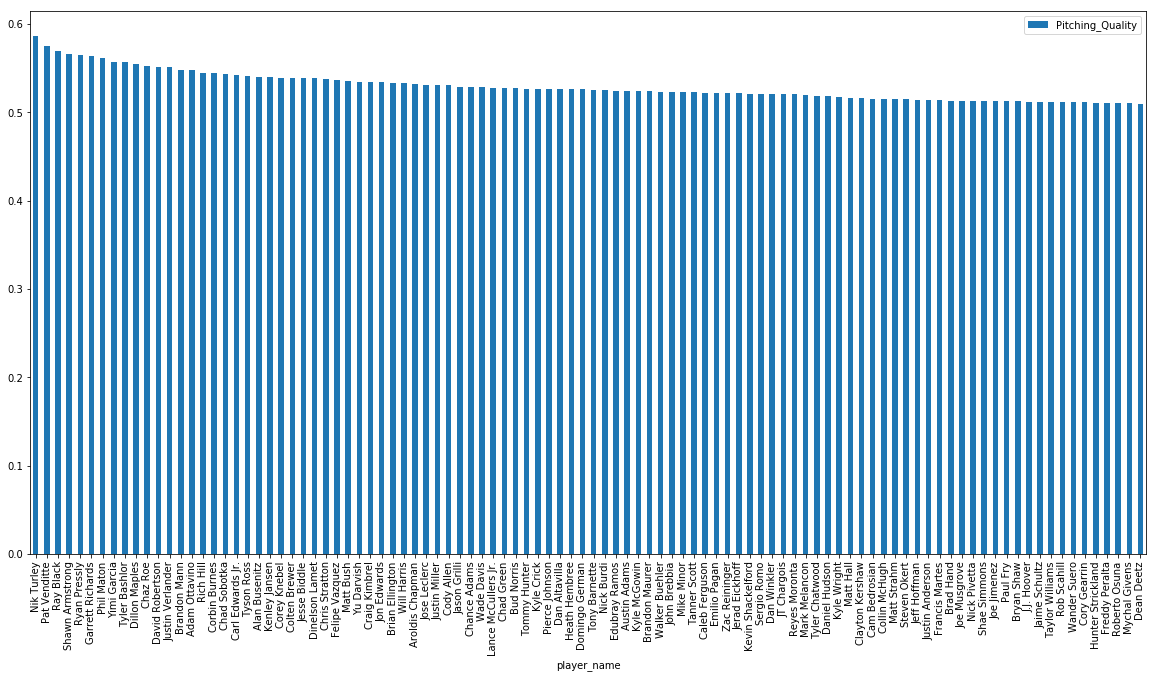

In [9]:
Updated_Data.head(100).plot.bar(x='player_name', y='Pitching_Quality', figsize=(20, 10))

The plot above shows a sample of the top 100 players according to this statistic. Now let's compare it to the top 100 pitchers using wOBA as an estimate.

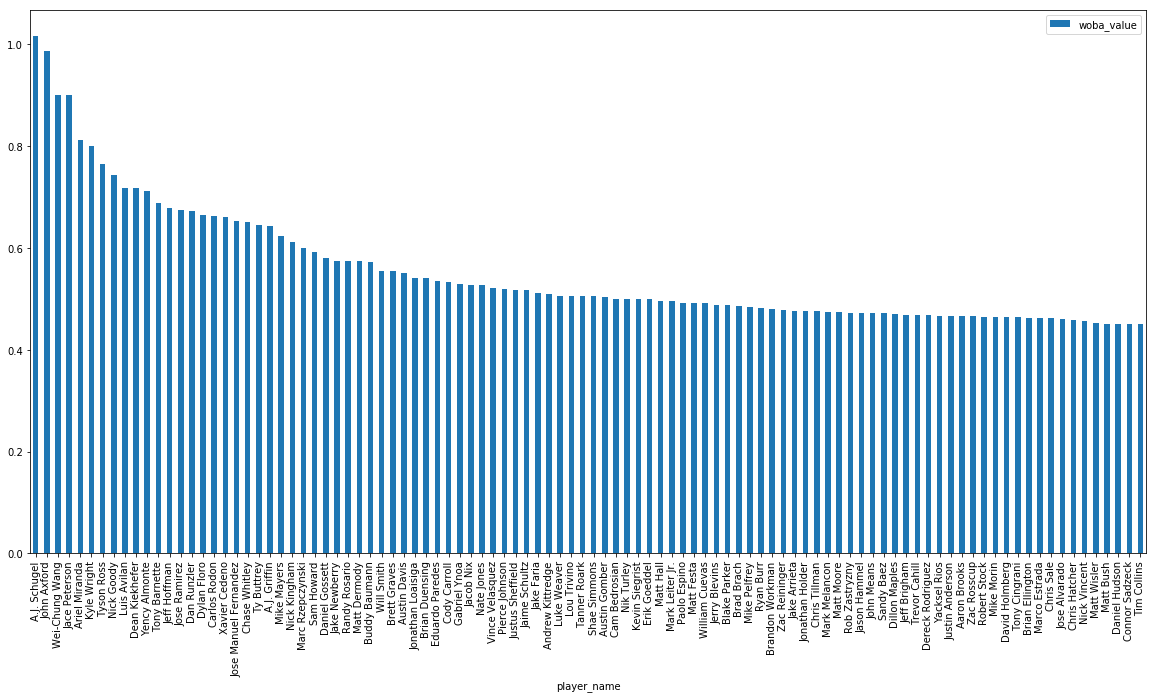

In [10]:
filtered_data.sort_values(by=['woba_value'], ascending=False).head(100).plot.bar(x='player_name', y='woba_value', figsize=(20, 10))

The wOBA statistic shows the offensive contributions of a player on a plate appearance, but I would like to see how offensiveness relates to the pitching quality.

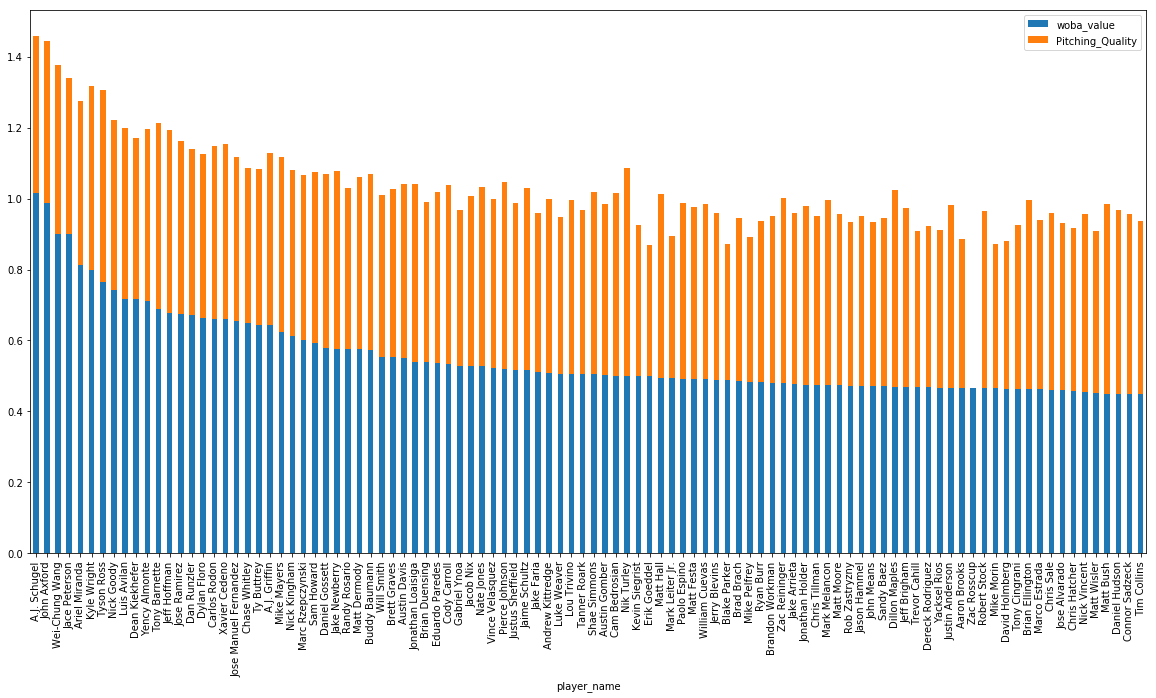

In [11]:
filtered_data.sort_values(by=['woba_value'], ascending=False).head(100).plot.bar(x='player_name', y=['woba_value', 'Pitching_Quality'], figsize=(20, 10), stacked=True)

Generally, it seems as if wOBA has a slight correlation to pitching quality, i.e the figure above is showing that a generally high wOBA score most likely relates to a high pitch quality.

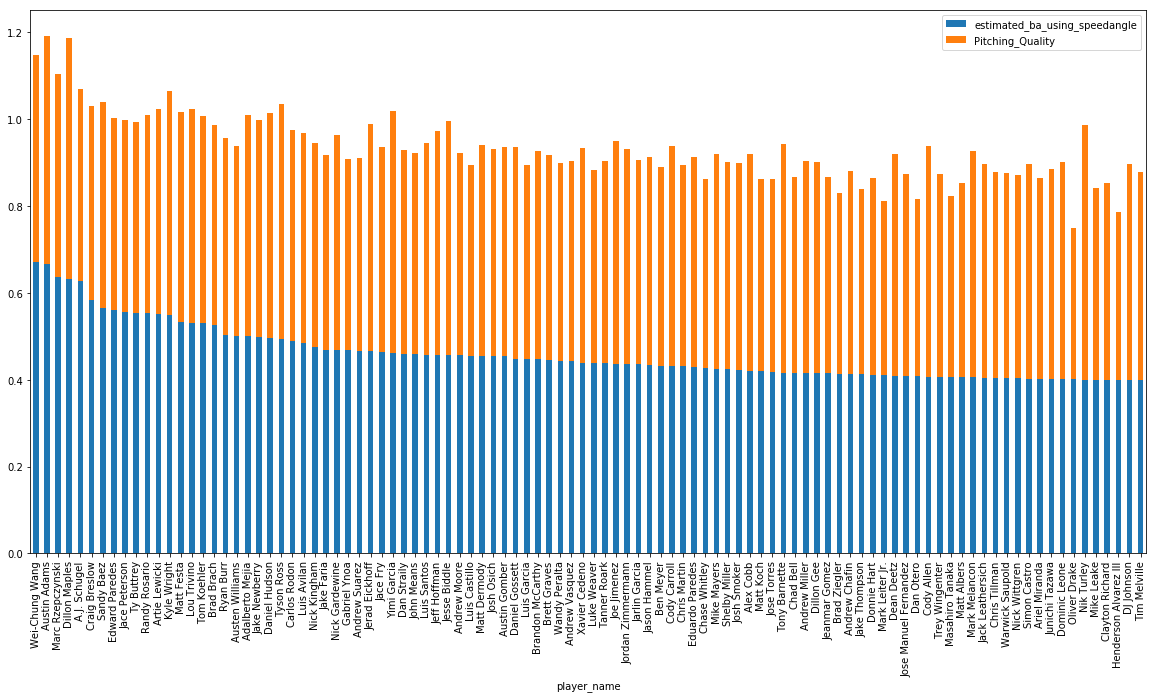

In [12]:
filtered_data.sort_values(by=['estimated_ba_using_speedangle'], ascending=False).head(100).plot.bar(x='player_name', y=['estimated_ba_using_speedangle', 'Pitching_Quality'], figsize=(20, 10), stacked=True)

Given our data, let's see how well our new statistic matches the others by pulling the top 20 players using each statistic:
#### wOBA

In [13]:
filtered_data.sort_values(by=['woba_value'], ascending=False).head(20)

,player_name,pitcher,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,launch_speed,launch_speed_angle,woba_value,estimated_ba_using_speedangle,Pitching_Quality
3,A.J. Schugel,519263,5.378207,-122.807768,-3.974014,-11.624157,24.676650,-24.567682,83.173500,2044.642857,93.120000,4.000000,1.016667,0.626250,0.442259
358,John Axford,446099,4.244777,-128.079485,-4.452246,-3.225554,27.918562,-26.666115,87.756154,2107.846154,91.000000,3.500000,0.987500,0.351750,0.456419
680,Wei-Chung Wang,623913,-4.910800,-124.289633,-3.861900,-2.103233,22.782267,-27.066400,84.532000,2303.666667,86.766667,4.000000,0.900000,0.670000,0.477668
292,Jace Peterson,607054,4.129390,-121.929047,-3.797967,-6.222763,23.323167,-20.446857,82.743567,2039.633333,86.377778,3.857143,0.900000,0.556000,0.440535
52,Ariel Miranda,664641,-5.260104,-126.935363,-6.635067,12.767263,26.554444,-14.611722,86.150889,2137.185185,79.188889,3.833333,0.812500,0.402333,0.460992
432,Kyle Wright,657140,5.256665,-132.430271,-5.225353,-2.172435,27.116476,-24.595618,91.046059,2434.882353,88.200000,4.666667,0.800000,0.547667,0.516959
667,Tyson Ross,475115,5.988619,-130.961241,-6.892419,-2.048252,25.387022,-24.132422,89.149889,2607.153846,87.837500,3.600000,0.764286,0.494600,0.540707
510,Nick Goody,580792,4.922048,-128.958014,-3.514362,-4.513203,25.716659,-16.855190,89.090172,2208.884615,83.600000,3.166667,0.742857,0.299833,0.478637
440,Luis Avilan,501593,-1.529308,-119.007654,-3.328831,6.253200,20.895638,-28.633023,80.927692,2302.538462,93.766667,3.666667,0.716667,0.483333,0.483464
201,Dean Kiekhefer,518883,-7.078665,-114.668347,-0.954676,2.596682,20.836776,-29.995976,78.137235,2246.235294,72.075000,2.666667,0.716667,0.258000,0.453983


#### Estimated BA

In [14]:
filtered_data.sort_values(by=['estimated_ba_using_speedangle'], ascending=False).head(20)

,player_name,pitcher,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,launch_speed,launch_speed_angle,woba_value,estimated_ba_using_speedangle,Pitching_Quality
680,Wei-Chung Wang,623913,-4.910800,-124.289633,-3.861900,-2.103233,22.782267,-27.066400,84.532000,2303.666667,86.766667,4.000000,0.900000,0.670000,0.477668
58,Austin Adams,613534,7.509855,-134.368160,-4.334730,1.462372,28.036257,-21.732381,91.925532,2536.476190,64.350000,4.000000,0.300000,0.667000,0.524700
453,Marc Rzepczynski,519240,-5.465708,-127.315600,-3.193767,6.476133,24.329742,-31.968958,86.693750,2279.750000,79.266667,3.000000,0.600000,0.637000,0.466860
210,Dillon Maples,596027,4.170490,-132.073760,-3.648713,3.796881,27.190150,-29.092131,90.230667,2664.375000,85.570000,4.200000,0.469231,0.631600,0.554570
3,A.J. Schugel,519263,5.378207,-122.807768,-3.974014,-11.624157,24.676650,-24.567682,83.173500,2044.642857,93.120000,4.000000,1.016667,0.626250,0.442259
169,Craig Breslow,444520,-8.765139,-123.790200,-2.117328,12.257400,24.658194,-22.269867,83.762500,2032.388889,90.180000,4.666667,0.430000,0.583333,0.445449
589,Sandy Baez,622783,7.433634,-133.825107,-5.850964,-9.810530,28.766664,-17.642481,90.986313,2189.800000,84.031250,4.000000,0.471429,0.564125,0.474182
234,Edward Paredes,487675,-7.268470,-122.329009,-1.095961,4.312596,21.413991,-24.276265,83.740000,2115.695652,75.150000,4.000000,0.225000,0.559500,0.442444
292,Jace Peterson,607054,4.129390,-121.929047,-3.797967,-6.222763,23.323167,-20.446857,82.743567,2039.633333,86.377778,3.857143,0.900000,0.556000,0.440535
655,Ty Buttrey,621142,4.589953,-131.711518,-5.655797,-12.687229,28.482591,-21.401747,89.505676,2023.588235,87.040000,3.625000,0.645000,0.553625,0.438713


And now:
#### Pitching Quality

In [15]:
filtered_data.sort_values(by=['Pitching_Quality'], ascending=False).head(20)

,player_name,pitcher,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,launch_speed,launch_speed_angle,woba_value,estimated_ba_using_speedangle,Pitching_Quality
517,Nik Turley,543867,-6.823205,-129.752862,-3.777267,3.192990,26.276162,-23.091043,89.361952,2838.095238,86.980000,3.666667,0.500000,0.400000,0.586006
526,Pat Venditte,519381,1.465767,-115.887578,1.920261,2.393361,22.111161,-26.632322,79.497722,2794.000000,81.880000,2.400000,0.116667,0.142600,0.575660
542,Ray Black,605143,6.922742,-135.540792,-3.794398,-0.409944,29.114568,-20.203228,92.817480,2748.979592,72.127778,2.625000,0.330769,0.383875,0.569683
606,Shawn Armstrong,542888,7.708582,-131.856105,-4.161079,-1.140330,27.602556,-20.844454,90.420404,2722.176471,77.050000,3.250000,0.446875,0.306875,0.566489
575,Ryan Pressly,519151,1.466149,-131.847819,-5.002214,2.872953,28.159767,-23.759620,89.850463,2741.989474,80.004348,2.857143,0.283333,0.247714,0.565116
259,Garrett Richards,572070,5.544795,-133.809761,-4.402649,-3.453745,28.273967,-27.164517,91.528934,2763.057851,76.300000,2.764706,0.241071,0.330529,0.563794
533,Phil Maton,664208,2.180922,-127.831611,-1.298925,1.327744,26.119330,-25.624069,88.500551,2690.829545,83.305000,3.363636,0.316667,0.365091,0.561955
691,Yimi Garcia,554340,7.548971,-131.198636,-0.776636,-1.380714,26.470636,-25.085550,89.477714,2667.500000,80.375000,3.000000,0.416667,0.460500,0.557000
657,Tyler Bashlor,641341,4.235161,-135.142709,-3.494510,-8.232219,31.177197,-17.901766,92.436740,2608.961039,84.678261,3.625000,0.353571,0.327250,0.556739
210,Dillon Maples,596027,4.170490,-132.073760,-3.648713,3.796881,27.190150,-29.092131,90.230667,2664.375000,85.570000,4.200000,0.469231,0.631600,0.554570


Here, we can see a small overlap in using both statistics. While BA and wOBA look at the offensive possibility of the pitches, the quality of the pitch is not considered. Comparing our results, we can see that Dillon Maples appears in the top x of Pitching Quality and estimated BA, Tyson Ross appears in the top 20 of Pitching Quality, as well as the top 10 wOBA.

I believe this can conculde a general importance of evaluating pitching quality as a measure of the possible offensiveness of a pitcher. I believe that we can use this statistic to predict how certain pitchers may climb the rankings.
